# XGBoost 분류 기본 코드

## #01. 기본 준비

### [1] 패키지 가져오기

기본 코드는 sklearn과 호환되지 않기 때문에 모듈화 해 둔 성능평가 함수( my_classification_result() )를 사용할 수 없다.

In [1]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# xgboost
import xgboost as xgb

# 성능평가도구
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기

In [2]:
origin = my_read_excel(
    path="https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx",
    categories=["Outcome"],
    info=False,
)


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 기본 데이터 처리

In [3]:
# 정제 대상 필드명
zero_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 훈련/검증 데이터 분할 및 데이터 표준화
x_train, x_test, y_train, y_test = my_train_test_split(df2, "Outcome", scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. XGBoost 훈련 모델 적합

### [1] XGBoost 전용 데이터 생성

사이킷런과 다른 점은 학습/테스트를 위한 `DMatrix`를 생성한다는 점이고, DMatrix는 numpy 입력 파라미터를 받아 만들어지는 XGBoost만의 전용 dataset이다. 주요 입력 파라미터는 data와 label이다.

#### (1) DMatrix 형식으로 변환

In [6]:
dtrain = xgb.DMatrix(data=x_train, label=y_train, feature_names=list(x_train.columns))
dtest = xgb.DMatrix(data=x_test, label=y_test, feature_names=list(x_test.columns))
dtrain, dtest

(<xgboost.core.DMatrix at 0x2650b377e90>,
 <xgboost.core.DMatrix at 0x2650b3b7490>)

#### (2) 훈련데이터와 검증데이터를 2차원 리스트로 묶음

`[(훈련데이터, 별칭), (검증데이터, 별칭)]` 형식으로 구성한다.

train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기한다. (고정이름)

In [7]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]
wlist

[(<xgboost.core.DMatrix at 0x2650b377e90>, 'train'),
 (<xgboost.core.DMatrix at 0x2650b3b7490>, 'eval')]

### [2] 학습 모델 적합

하이퍼파라미터의 자세한 설명은 다음 예제에서 소개합니다.

In [8]:
estimator = xgb.train(
    params={
        'booster':'gbtree',
        'device': 'cpu',
        'eta': 0.1,
        'max_depth': 3,
        'objective': 'binary:logistic',
        'eval_metric': 'error',
        'early_stoppings':5
    },
    dtrain=dtrain,
    num_boost_round=400,
    evals=wlist
)

[0]	train-error:0.35993	eval-error:0.30519
[1]	train-error:0.35993	eval-error:0.30519
[2]	train-error:0.35993	eval-error:0.30519
[3]	train-error:0.27199	eval-error:0.22078
[4]	train-error:0.26710	eval-error:0.22078
[5]	train-error:0.26710	eval-error:0.22078
[6]	train-error:0.26221	eval-error:0.20130
[7]	train-error:0.22313	eval-error:0.21429
[8]	train-error:0.22150	eval-error:0.18831
[9]	train-error:0.21336	eval-error:0.18182
[10]	train-error:0.20358	eval-error:0.18831
[11]	train-error:0.21336	eval-error:0.20130
[12]	train-error:0.20521	eval-error:0.20779
[13]	train-error:0.20521	eval-error:0.21429
[14]	train-error:0.20684	eval-error:0.21429
[15]	train-error:0.20195	eval-error:0.20130
[16]	train-error:0.19381	eval-error:0.19481
[17]	train-error:0.18730	eval-error:0.19481
[18]	train-error:0.18730	eval-error:0.19481
[19]	train-error:0.19544	eval-error:0.19481
[20]	train-error:0.18893	eval-error:0.19481
[21]	train-error:0.18893	eval-error:0.19481
[22]	train-error:0.19055	eval-error:0.1883

### [3] 학습 결과 확인

#### (1) 예측 확률

In [9]:
pred_probs = estimator.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(a=pred_probs[:10], decimals=3))
                        

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.974 0.059 0.014 0.868 0.027 0.007 0.805 0.985 0.077 0.432]


#### (2) 예측값

다소 불편하지만 예측값은 직접 계산해야 한다.

In [10]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 결정하여 list 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',  preds[:10])
                            

예측값 10개만 표시: [1, 0, 0, 1, 0, 0, 1, 1, 0, 0]


#### (3) 혼동행렬

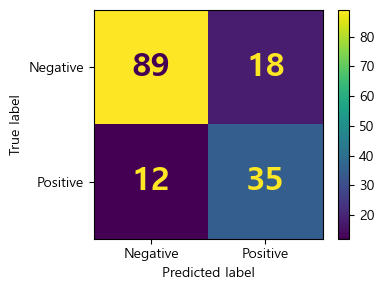

In [11]:
my_confusion_matrix(y=y_test,y_pred=preds)

#### (4) 성능평가 지표

In [13]:
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds)
recall = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
roc_auc = roc_auc_score(y_test, pred_probs)
print('정확도:{0:.4f}, 정밀도:{1:.4f}, 재현율:{2:.4f}, F1:{3:.4f},AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


정확도:0.8052, 정밀도:0.6604, 재현율:0.7447, F1:0.7000,AUC:0.8399


#### (5) 각 변수별 중요도 확인

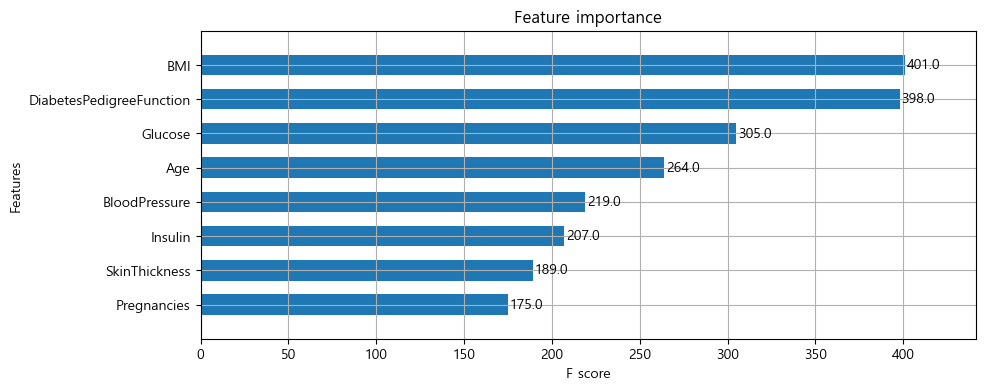

In [14]:
fig = plt.figure(figsize=(10,4), dpi=100)
ax=fig.gca()
xgb.plot_importance(estimator, height=0.6, ax=ax)
plt.show()
plt.close()

#### (6) 분류 과정 트리 확인

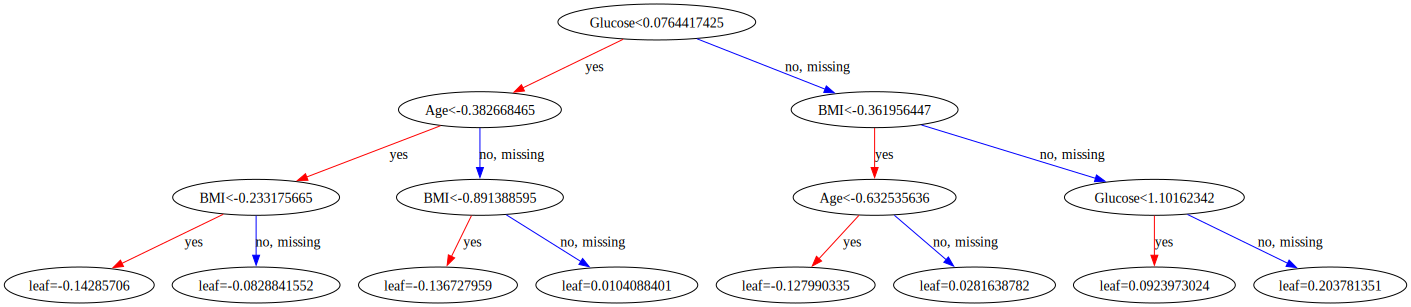

In [15]:
xgb.to_graphviz(estimator)